In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [3]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [4]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [5]:
from models.CRNN import CRNN_model

# 1. Data

In [6]:
strategy = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-11-22 16:06:25,665 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:06:25,668 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:06:25,668 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [7]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

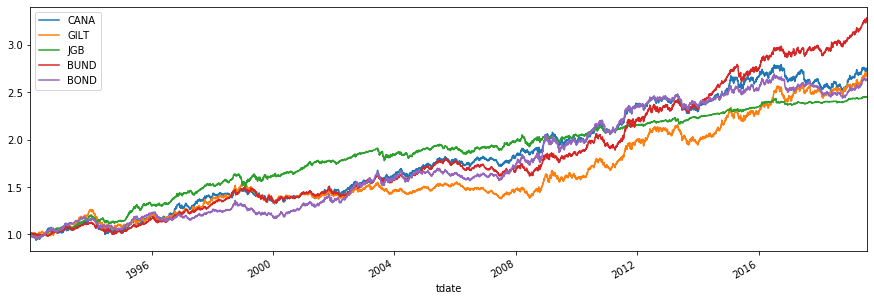

In [8]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

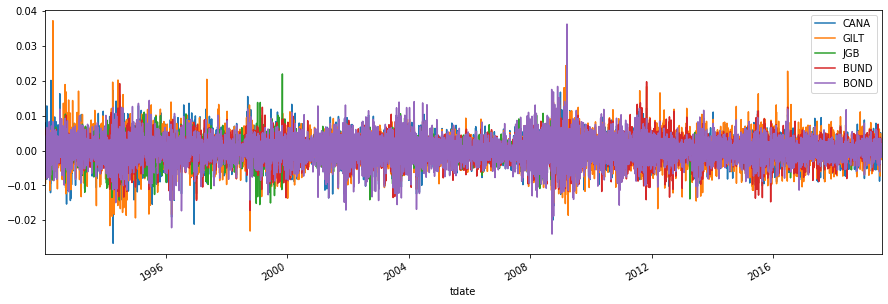

In [9]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

In [10]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 252]

# 1. FEATURE

### average return

In [11]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [12]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [13]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [14]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

# 2. 성과

# CASE 0. 기존(머신러닝 사용 X)

In [15]:
from IPM import IPM

In [16]:
ipm = IPM(strategy_name="IPM", asset_type="IR")
ipm.load_index_and_return(from_db=False, save_file=False)
ipm.set_rebalance_period(freq='month')
ipm.calculate_signal(CS=0.5, nopos=0.4, minobs=260, minobs1=52, longlen=52, shortlen=4)
ipm.set_portfolio_parameter(cs_strategy_type='vol', min_vol=0.04)
ipm.make_portfolio()

2019-11-22 16:06:26,428 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:06:26,428 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:06:26,429 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:06:26,429 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:06:26,430 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:06:26,430 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:06:26,452 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-22 16:06:26,452 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\IPM.py:74: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\IPM.py:75: FutureWarning:


In [17]:
start_date = '2011-01-01'
end_date = '2018-05-09'

# get r results
ipm_comp_df = pd.read_csv('../check/past/ipm.csv', header=0, index_col=0, parse_dates=True)
ipm_lag_comp_df = pd.read_csv('../check/past/ipm_lag.csv', header=0, index_col=0, parse_dates=True)

### 1. PYTHON & R

In [18]:
tester = Tester(ipm)
tester.set_period(start=start_date, end=end_date)
tester.run()

2019-11-22 16:06:41,250 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:06:41,250 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:06:41,251 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:06:41,251 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:06:41,646 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-11-22 16:06:41,646 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL


In [19]:
to_plot = (1.+ ipm_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [20]:
one_month = 20
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [21]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [22]:
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2007-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2008-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [23]:
def train_tree(train_x, train_y1, val_x, val_y1, max_depth=7, fraction=0.8, num_leaves=50, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, random_state=1, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': max_depth,
          'num_leaves': num_leaves,
          "learning_rate": learning_rate,
          "feature_fraction": fraction,
          "subsample": fraction,
          "verbosity": verbose,
          "metric": 'binary_logloss',
          'random_state': random_state
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [24]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.67259	valid_1's binary_logloss: 0.672913
[20]	training's binary_logloss: 0.672177	valid_1's binary_logloss: 0.672812
[30]	training's binary_logloss: 0.671771	valid_1's binary_logloss: 0.672717
[40]	training's binary_logloss: 0.671381	valid_1's binary_logloss: 0.672661
[50]	training's binary_logloss: 0.670992	valid_1's binary_logloss: 0.672548
[60]	training's binary_logloss: 0.670601	valid_1's binary_logloss: 0.672499
[70]	training's binary_logloss: 0.670219	valid_1's binary_logloss: 0.672431
[80]	training's binary_logloss: 0.669859	valid_1's binary_logloss: 0.672384
[90]	training's binary_logloss: 0.669476	valid_1's binary_logloss: 0.672305
[100]	training's binary_logloss: 0.669108	valid_1's binary_logloss: 0.672291
[110]	training's binary_logloss: 0.668733	valid_1's binary_logloss: 0.672262
[120]	training's binary_logloss: 0.668366	valid_1's binary_logloss: 0.672256
[130]	training's binary_

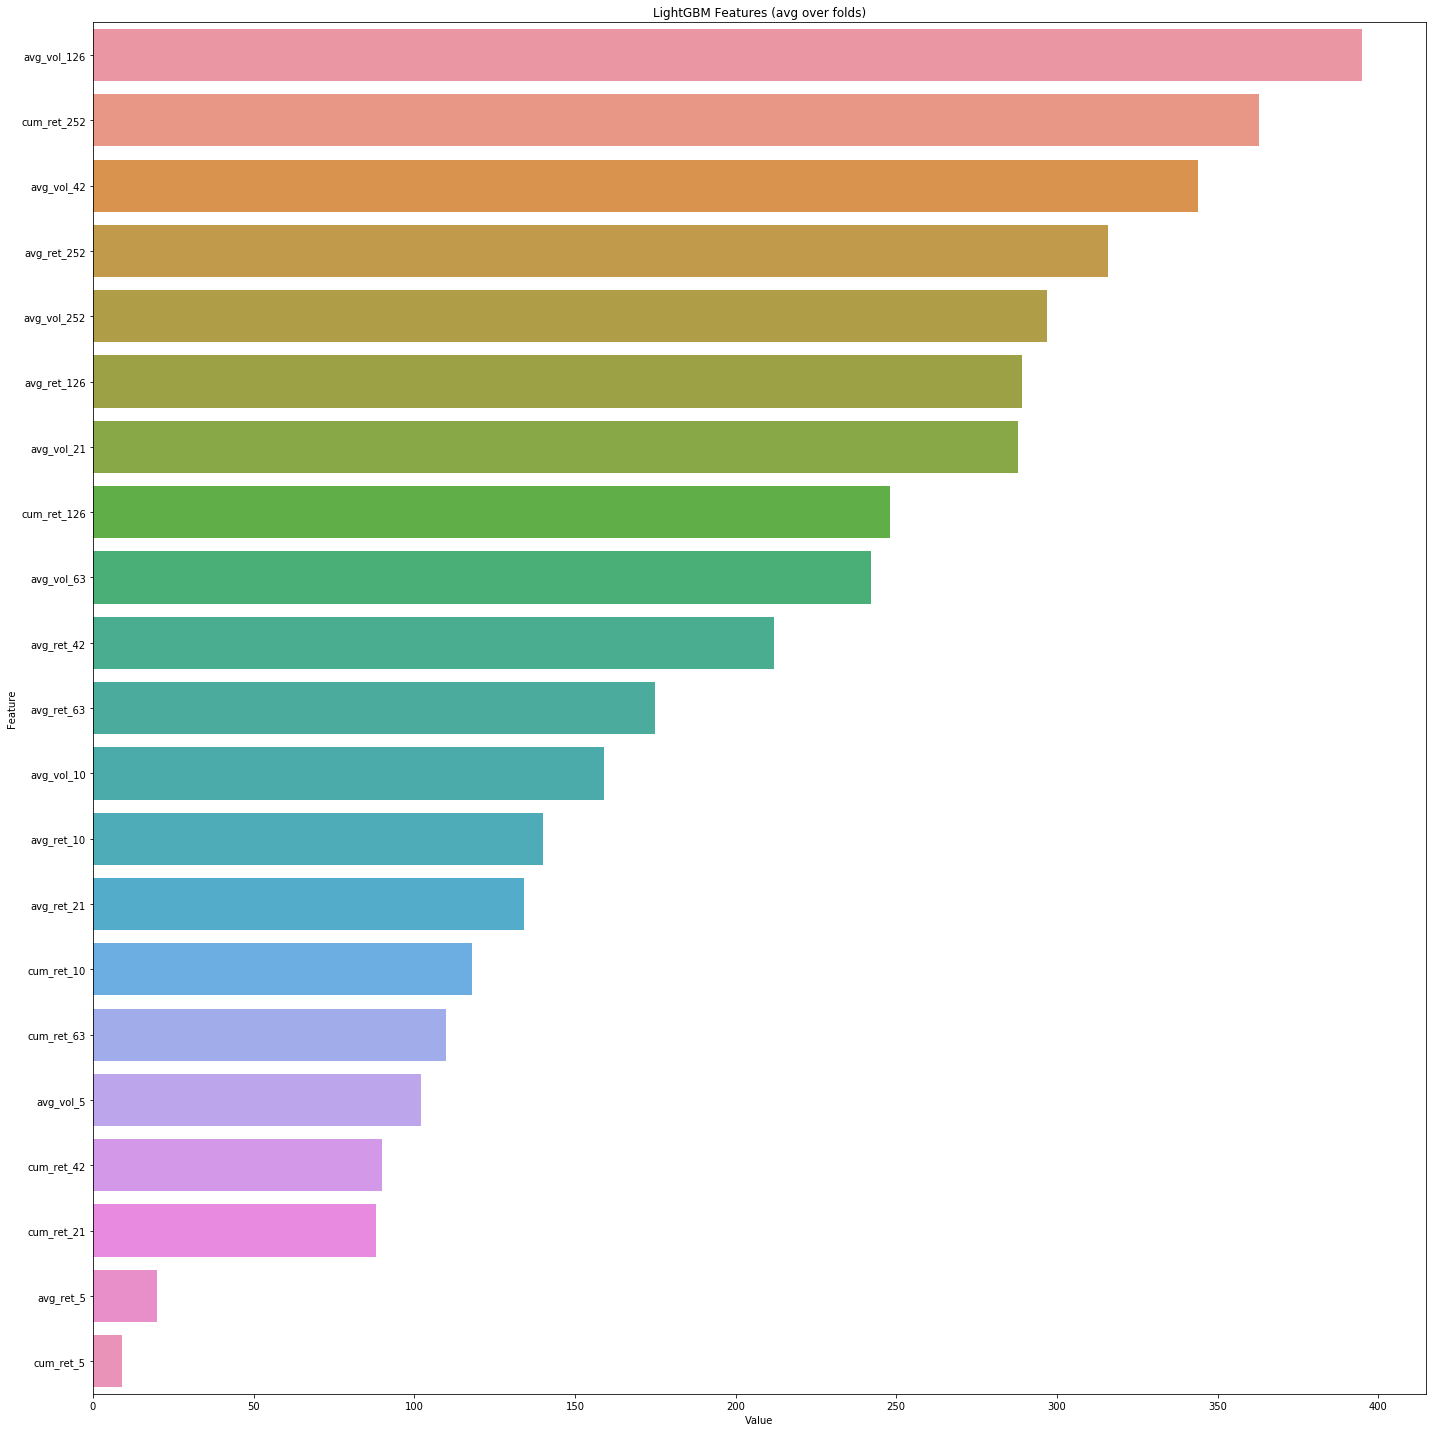

In [25]:
supply_demand_feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), df_train.columns[3:])), columns=['Value','Feature'])
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=supply_demand_feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [26]:
test_pred = model.predict(df_test_x.values)

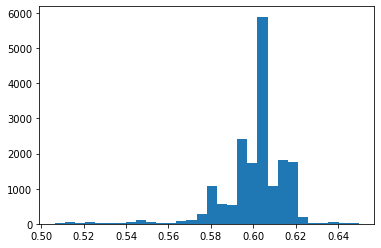

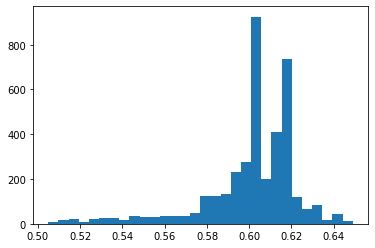

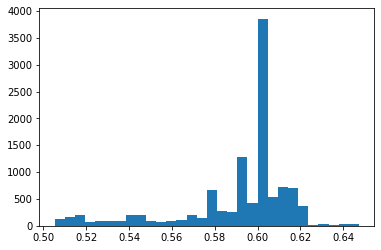

In [27]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [28]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')
df_pred = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [29]:
df_index_sub = df_index.loc['1994':]
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [30]:
strategy.set_rebalance_period(freq='month')
tester = Tester(strategy)
strategy.set_portfolio_parameter(cs_strategy_type='vol', min_vol=0.04)
strategy.make_portfolio()

2019-11-22 16:06:43,959 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-22 16:06:43,959 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-22 16:06:43,960 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-22 16:06:43,960 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-22 16:06:43,961 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-22 16:06:43,961 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-22 16:06:43,962 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-22 16:06:43,962 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-22 16:06:49,705 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-11-22 16:06:49,705 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-11-22 16:06:49,706 - IPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-11-22 16:06:49,706 - IPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-11-22 16:06:51,995 - IPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-11-22 16:06:51,995 - IPM - 

### TEST

In [31]:
tester1 = Tester(strategy)
tester1.set_period(start=start_date, end=end_date)
tester1.run()

2019-11-22 16:06:58,392 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:06:58,392 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:06:58,394 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:06:58,394 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:06:58,604 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-11-22 16:06:58,604 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL


In [32]:
to_plot['CS_ML'] = tester1.strategy.CS_result

In [33]:
to_plot.iplot()

# CASE 2. 70% 강조

- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [34]:
df_index_y_binary1 = df_index_rank > df_index_rank.shape[1] / 4 * 3
df_index_y_binary1 = df_index_y_binary1.astype(np.float32)
df_y = df_index_y_binary1.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [35]:
df_join2 = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2007-12-31')]
df_val = df_join2.loc[(df_join2['tdate'] >= pd.to_datetime('2008-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join2.loc[df_join2['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [36]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.672562	valid_1's binary_logloss: 0.673026
[20]	training's binary_logloss: 0.672143	valid_1's binary_logloss: 0.673013
[30]	training's binary_logloss: 0.671718	valid_1's binary_logloss: 0.673059
[40]	training's binary_logloss: 0.671321	valid_1's binary_logloss: 0.673085
[50]	training's binary_logloss: 0.670909	valid_1's binary_logloss: 0.673123
[60]	training's binary_logloss: 0.670521	valid_1's binary_logloss: 0.673136
[70]	training's binary_logloss: 0.670114	valid_1's binary_logloss: 0.673191
[80]	training's binary_logloss: 0.669731	valid_1's binary_logloss: 0.673221
[90]	training's binary_logloss: 0.669322	valid_1's binary_logloss: 0.67321
[100]	training's binary_logloss: 0.668932	valid_1's binary_logloss: 0.673224
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.672921	valid_1's binary_logloss: 0.673008


In [37]:
test_pred = model.predict(df_test_x.values)

In [38]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

df_pred2 = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [39]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3
df_pred_rank2 = df_pred2.rank(axis=1)
df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [40]:
strategy2 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy2.load_index_and_return(from_db=False, save_file=False)
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2
strategy2.set_rebalance_period(freq='month') 
strategy2.set_portfolio_parameter(cs_strategy_type='vol', min_vol=0.04)
strategy2.make_portfolio()

2019-11-22 16:06:59,940 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:06:59,940 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:06:59,940 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:06:59,942 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:06:59,942 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:06:59,942 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:06:59,944 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:06:59,944 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:06:59,944 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:06:59,978 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-22 16:06:59,978 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-22 16:06:59,978 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-22 16:06:59,980 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-22 16:06:59,980 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-22 16:06:59,980 - IPM - INFO - [STEP 4] SET PORTFOLIO

### TEST

In [41]:
tester2 = Tester(strategy2)
tester2.set_period(start=start_date, end=end_date)
tester2.run()

2019-11-22 16:07:14,240 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:14,240 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:14,240 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:14,241 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:14,241 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:14,241 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:14,471 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-11-22 16:07:14,471 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-11-22 16:07:14,471 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL


In [42]:
to_plot['CS_ML_UPPER'] = tester2.strategy.CS_result

In [43]:
to_plot.iplot()

In [44]:
result = pd.concat([ipm.CS_summary,
                    ipm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary], axis=1)

In [45]:
result

0         1         2         3
TURNOVER   4.453287  2.096635  4.138086  3.941440
MDD       -0.024602 -0.049429 -0.028038 -0.036332
CAGR       0.016630  0.012742  0.017247  0.004848
CAGR_TR   -0.003209  0.004402  0.005958 -0.013848
VOL        0.001292  0.001283  0.001265  0.001225
SHARPE     0.797926  0.619337  0.846178  0.253365
SHARPE_TR -0.142618  0.221624  0.300840 -0.691565

In [46]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER']

# CASE 3. Case1을 Rolling으로 실행

In [47]:
val_rolling_one_year = ['2007-12-31',
                    '2008-12-31',
                    '2009-12-31',
                    '2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31']

In [48]:
test_rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [49]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [50]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.672606	valid_1's binary_logloss: 0.672919
[20]	training's binary_logloss: 0.672184	valid_1's binary_logloss: 0.672811
[30]	training's binary_logloss: 0.6718	valid_1's binary_logloss: 0.672728
[40]	training's binary_logloss: 0.671407	valid_1's binary_logloss: 0.672627
[50]	training's binary_logloss: 0.671011	valid_1's binary_logloss: 0.672521
[60]	training's binary_logloss: 0.670601	valid_1's binary_logloss: 0.672447
[70]	training's binary_logloss: 0.670207	valid_1's binary_logloss: 0.672357
[80]	training's binary_logloss: 0.669839	valid_1's binary_logloss: 0.672277
[90]	training's binary_logloss: 0.669457	valid_1's binary_logloss: 0.672262
[100]	training's binary_logloss: 0.66908	valid_1's binary_logloss: 0.672238
[110]	training's binary_logloss: 0.668707	valid_1's binary_logloss: 0.672175
[120]	training's binary_logloss: 0.668339	valid_1's binary_logloss: 0.672142
[130]	training's binary_lo

[790]	training's binary_logloss: 0.650661	valid_1's binary_logloss: 0.665415
[800]	training's binary_logloss: 0.650457	valid_1's binary_logloss: 0.665415
[810]	training's binary_logloss: 0.650238	valid_1's binary_logloss: 0.665415
[820]	training's binary_logloss: 0.650032	valid_1's binary_logloss: 0.665438
[830]	training's binary_logloss: 0.649829	valid_1's binary_logloss: 0.665408
[840]	training's binary_logloss: 0.649626	valid_1's binary_logloss: 0.66541
[850]	training's binary_logloss: 0.649424	valid_1's binary_logloss: 0.665426
[860]	training's binary_logloss: 0.649238	valid_1's binary_logloss: 0.665443
[870]	training's binary_logloss: 0.649025	valid_1's binary_logloss: 0.665426
[880]	training's binary_logloss: 0.648813	valid_1's binary_logloss: 0.665442
[890]	training's binary_logloss: 0.648585	valid_1's binary_logloss: 0.665439
[900]	training's binary_logloss: 0.648366	valid_1's binary_logloss: 0.665438
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.650335	

[420]	training's binary_logloss: 0.660992	valid_1's binary_logloss: 0.668271
[430]	training's binary_logloss: 0.660747	valid_1's binary_logloss: 0.668232
[440]	training's binary_logloss: 0.660503	valid_1's binary_logloss: 0.668189
[450]	training's binary_logloss: 0.660255	valid_1's binary_logloss: 0.668193
[460]	training's binary_logloss: 0.660003	valid_1's binary_logloss: 0.668181
[470]	training's binary_logloss: 0.659755	valid_1's binary_logloss: 0.668151
[480]	training's binary_logloss: 0.659515	valid_1's binary_logloss: 0.668111
[490]	training's binary_logloss: 0.659277	valid_1's binary_logloss: 0.668128
[500]	training's binary_logloss: 0.659039	valid_1's binary_logloss: 0.668107
[510]	training's binary_logloss: 0.658798	valid_1's binary_logloss: 0.668066
[520]	training's binary_logloss: 0.658558	valid_1's binary_logloss: 0.668057
[530]	training's binary_logloss: 0.658316	valid_1's binary_logloss: 0.66802
[540]	training's binary_logloss: 0.658081	valid_1's binary_logloss: 0.668012


[680]	training's binary_logloss: 0.654498	valid_1's binary_logloss: 0.66477
[690]	training's binary_logloss: 0.654284	valid_1's binary_logloss: 0.664829
[700]	training's binary_logloss: 0.654076	valid_1's binary_logloss: 0.664867
[710]	training's binary_logloss: 0.653877	valid_1's binary_logloss: 0.664892
[720]	training's binary_logloss: 0.653676	valid_1's binary_logloss: 0.66491
[730]	training's binary_logloss: 0.653467	valid_1's binary_logloss: 0.664917
[740]	training's binary_logloss: 0.653258	valid_1's binary_logloss: 0.664935
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.655392	valid_1's binary_logloss: 0.664709
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.672668	valid_1's binary_logloss: 0.673014
[20]	training's binary_logloss: 0.672315	valid_1's binary_logloss: 0.673033
[30]	training's binary_logloss: 0.671964	valid_1's binary_logloss: 0.673077
[40]	training's binary_logloss: 0.671616	valid_1's binary_log

[710]	training's binary_logloss: 0.655268	valid_1's binary_logloss: 0.670829
[720]	training's binary_logloss: 0.655074	valid_1's binary_logloss: 0.670814
[730]	training's binary_logloss: 0.654873	valid_1's binary_logloss: 0.670788
[740]	training's binary_logloss: 0.654671	valid_1's binary_logloss: 0.670754
[750]	training's binary_logloss: 0.654486	valid_1's binary_logloss: 0.670764
[760]	training's binary_logloss: 0.6543	valid_1's binary_logloss: 0.670787
[770]	training's binary_logloss: 0.654114	valid_1's binary_logloss: 0.670775
[780]	training's binary_logloss: 0.653939	valid_1's binary_logloss: 0.670773
[790]	training's binary_logloss: 0.653761	valid_1's binary_logloss: 0.670765
[800]	training's binary_logloss: 0.65359	valid_1's binary_logloss: 0.670742
[810]	training's binary_logloss: 0.653416	valid_1's binary_logloss: 0.670749
[820]	training's binary_logloss: 0.653243	valid_1's binary_logloss: 0.670758
[830]	training's binary_logloss: 0.653064	valid_1's binary_logloss: 0.670744
[8

In [51]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([6.300e+01, 6.200e+01, 6.600e+01, 3.900e+01, 3.800e+01, 4.300e+01,
        5.500e+01, 7.200e+01, 7.800e+01, 4.200e+01, 5.700e+01, 6.300e+01,
        4.000e+01, 1.400e+02, 1.510e+02, 6.500e+01, 1.290e+02, 2.670e+02,
        4.300e+02, 6.940e+02, 1.201e+03, 5.657e+03, 1.231e+03, 2.630e+02,
        1.090e+02, 7.000e+01, 1.800e+01, 1.300e+01, 1.000e+00, 3.000e+00]),
 array([0.34224832, 0.35444236, 0.36663641, 0.37883045, 0.39102449,
        0.40321854, 0.41541258, 0.42760663, 0.43980067, 0.45199472,
        0.46418876, 0.4763828 , 0.48857685, 0.50077089, 0.51296494,
        0.52515898, 0.53735302, 0.54954707, 0.56174111, 0.57393516,
        0.5861292 , 0.59832324, 0.61051729, 0.62271133, 0.63490538,
        0.64709942, 0.65929346, 0.67148751, 0.68368155, 0.6958756 ,
        0.70806964]),
 <a list of 30 Patch objects>)

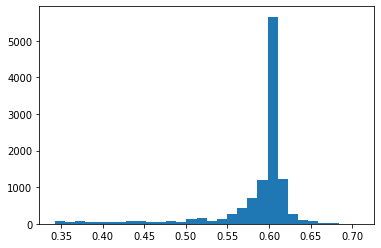

In [52]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [53]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [54]:
strategy3 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy3.load_index_and_return(from_db=False, save_file=False)
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3
strategy3.set_rebalance_period(freq='month') 
strategy3.set_portfolio_parameter(cs_strategy_type='vol', min_vol=0.04)
strategy3.make_portfolio()

2019-11-22 16:07:22,147 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:07:22,147 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:07:22,147 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:07:22,147 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:07:22,149 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:07:22,149 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:07:22,149 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:07:22,149 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:07:22,150 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:07:22,150 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:07:22,150 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:07:22,150 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:07:22,173 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-22 16:07:22,173 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-22 16:07:22,173 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-2

In [55]:
tester3 = Tester(strategy3)
tester3.set_period(start=start_date, end=end_date)
tester3.run()

2019-11-22 16:07:30,891 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:30,891 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:30,891 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:30,891 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:30,893 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:30,893 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:30,893 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:30,893 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:31,107 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-11-22 16:07:31,107 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-11-22 16:07:31,107 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-11-22 16:07:31,107 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL


In [56]:
to_plot['CS_ML_ROLLING'] = tester3.strategy.CS_result

In [57]:
to_plot.iplot()

In [58]:
result = pd.concat([ipm.CS_summary,
                    ipm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary], axis=1)

In [59]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING']

In [60]:
result

CS_python  TS_python     CS_ML  CS_ML_UPPER  CS_ML_ROLLING
TURNOVER    4.453287   2.096635  4.138086     3.941440       3.819355
MDD        -0.024602  -0.049429 -0.028038    -0.036332      -0.052593
CAGR        0.016630   0.012742  0.017247     0.004848       0.008404
CAGR_TR    -0.003209   0.004402  0.005958    -0.013848      -0.007780
VOL         0.001292   0.001283  0.001265     0.001225       0.001265
SHARPE      0.797926   0.619337  0.846178     0.253365       0.418346
SHARPE_TR  -0.142618   0.221624  0.300840    -0.691565      -0.370276

# CASE 4. CASE 2를 ROLLING으로 실행

In [61]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [62]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join2.loc[df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join2.loc[(df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.672592	valid_1's binary_logloss: 0.672981
[20]	training's binary_logloss: 0.672158	valid_1's binary_logloss: 0.672962
[30]	training's binary_logloss: 0.67175	valid_1's binary_logloss: 0.673003
[40]	training's binary_logloss: 0.671331	valid_1's binary_logloss: 0.673085
[50]	training's binary_logloss: 0.670925	valid_1's binary_logloss: 0.673098
[60]	training's binary_logloss: 0.670506	valid_1's binary_logloss: 0.673124
[70]	training's binary_logloss: 0.670101	valid_1's binary_logloss: 0.673188
[80]	training's binary_logloss: 0.669709	valid_1's binary_logloss: 0.673161
[90]	training's binary_logloss: 0.669326	valid_1's binary_logloss: 0.673161
[100]	training's binary_logloss: 0.668929	valid_1's binary_logloss: 0.6732
[110]	training's binary_logloss: 0.668545	valid_1's binary_logloss: 0.673234
[120]	training's binary_logloss: 0.668162	valid_1's binary_logloss: 0.673218
Early stopping, best itera

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.672677	valid_1's binary_logloss: 0.673005
[20]	training's binary_logloss: 0.672326	valid_1's binary_logloss: 0.673015
[30]	training's binary_logloss: 0.67198	valid_1's binary_logloss: 0.672994
[40]	training's binary_logloss: 0.671627	valid_1's binary_logloss: 0.672999
[50]	training's binary_logloss: 0.671288	valid_1's binary_logloss: 0.673016
[60]	training's binary_logloss: 0.67095	valid_1's binary_logloss: 0.673061
[70]	training's binary_logloss: 0.670623	valid_1's binary_logloss: 0.673062
[80]	training's binary_logloss: 0.67031	valid_1's binary_logloss: 0.673101
[90]	training's binary_logloss: 0.669981	valid_1's binary_logloss: 0.673101
[100]	training's binary_logloss: 0.669652	valid_1's binary_logloss: 0.673115
[110]	training's binary_logloss: 0.669338	valid_1's binary_logloss: 0.673139
[120]	training's binary_logloss: 0.669029	valid_1's binary_logloss: 0.673117
[130]	training's binary_lo

[260]	training's binary_logloss: 0.66509	valid_1's binary_logloss: 0.672666
[270]	training's binary_logloss: 0.664832	valid_1's binary_logloss: 0.672689
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.667414	valid_1's binary_logloss: 0.672628
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.672681	valid_1's binary_logloss: 0.672989
[20]	training's binary_logloss: 0.672358	valid_1's binary_logloss: 0.67295
[30]	training's binary_logloss: 0.672033	valid_1's binary_logloss: 0.67291
[40]	training's binary_logloss: 0.671718	valid_1's binary_logloss: 0.672869
[50]	training's binary_logloss: 0.671411	valid_1's binary_logloss: 0.672833
[60]	training's binary_logloss: 0.671092	valid_1's binary_logloss: 0.672806
[70]	training's binary_logloss: 0.670775	valid_1's binary_logloss: 0.67278
[80]	training's binary_logloss: 0.670449	valid_1's binary_logloss: 0.672776
[90]	training's binary_logloss: 0.670146	valid_1's binary_logloss: 0

In [63]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [64]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [65]:
strategy4 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4
strategy4.set_rebalance_period(freq='month') 
strategy4.set_portfolio_parameter(cs_strategy_type='vol', min_vol=0.04)
strategy4.make_portfolio()

2019-11-22 16:07:35,768 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:07:35,768 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:07:35,768 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:07:35,768 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:07:35,768 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-11-22 16:07:35,771 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:07:35,771 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:07:35,771 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:07:35,771 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:07:35,771 - IPM - INFO - [STEP 1] LOAD DATA
2019-11-22 16:07:35,773 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:07:35,773 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:07:35,773 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:07:35,773 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:07:35,773 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 16:07:35,

In [66]:
tester4 = Tester(strategy4)
tester4.set_period(start=start_date, end=end_date)
tester4.run()

2019-11-22 16:07:44,511 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:44,511 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:44,511 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:44,511 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:44,511 - IPM - INFO - [STEP 6] START BACKTEST
2019-11-22 16:07:44,514 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:44,514 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:44,514 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:44,514 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:44,514 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-11-22 16:07:44,709 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-11-22 16:07:44,709 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-11-22 16:07:44,709 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-11-22 16:07:44,709 - IPM - INFO - [STEP 6 - 2] BACKT

In [67]:
to_plot['CS_ML_UPPER_ROLLING'] = tester4.strategy.CS_result

In [68]:
to_plot.iplot()

In [69]:
result = pd.concat([ipm.CS_summary,
                    ipm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary,
                    strategy4.CS_summary], axis=1)

In [70]:
result

0         1         2         3         4         5
TURNOVER   4.453287  2.096635  4.138086  3.941440  3.819355  4.708177
MDD       -0.024602 -0.049429 -0.028038 -0.036332 -0.052593 -0.037744
CAGR       0.016630  0.012742  0.017247  0.004848  0.008404  0.019298
CAGR_TR   -0.003209  0.004402  0.005958 -0.013848 -0.007780  0.000427
VOL        0.001292  0.001283  0.001265  0.001225  0.001265  0.001264
SHARPE     0.797926  0.619337  0.846178  0.253365  0.418346  0.943676
SHARPE_TR -0.142618  0.221624  0.300840 -0.691565 -0.370276  0.032038

In [71]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING', 'CS_ML_UPPER_ROLING']

In [72]:
result

CS_python  TS_python     CS_ML  CS_ML_UPPER  CS_ML_ROLLING  \
TURNOVER    4.453287   2.096635  4.138086     3.941440       3.819355   
MDD        -0.024602  -0.049429 -0.028038    -0.036332      -0.052593   
CAGR        0.016630   0.012742  0.017247     0.004848       0.008404   
CAGR_TR    -0.003209   0.004402  0.005958    -0.013848      -0.007780   
VOL         0.001292   0.001283  0.001265     0.001225       0.001265   
SHARPE      0.797926   0.619337  0.846178     0.253365       0.418346   
SHARPE_TR  -0.142618   0.221624  0.300840    -0.691565      -0.370276   

           CS_ML_UPPER_ROLING  
TURNOVER             4.708177  
MDD                 -0.037744  
CAGR                 0.019298  
CAGR_TR              0.000427  
VOL                  0.001264  
SHARPE               0.943676  
SHARPE_TR            0.032038